<a href="https://colab.research.google.com/github/AryanGupta0419/TumorDetection/blob/main/TumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torch
from torch.utils.data import random_split,DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
!pip install opendatasets

In [ ]:
#upload kaggle api key
from google.colab import files
files.upload()

{}

# 1.0 Importing Dataset and Data Visualization

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


100%|██████████| 15.1M/15.1M [00:00<00:00, 123MB/s] 

## 1.1 Creating a list with file_name of every image

Random image path: /content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no/10 no.jpg
Image class: no
Image height: 201
Image width: 173


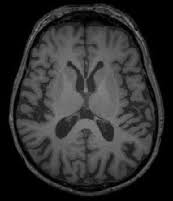

In [ ]:
from pathlib import Path
img_path = Path("/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")


import random
from PIL import Image

img_path_list = list(img_path.glob("*/*.jpeg"))
img_path_list += list(img_path.glob("*/*.jpg"))
img_path_list += list(img_path.glob("*/*.JPG"))

random_img_path = random.choice(img_path_list)

# 3. Get image class from path name
img_class = random_img_path.parent.stem

img = Image.open(random_img_path)

# 5. Print metadata
print(f"Random image path: {random_img_path}")
print(f"Image class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
])

transform(img).shape

torch.Size([3, 224, 224])

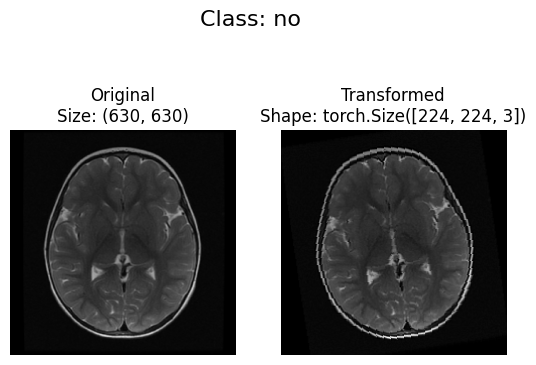

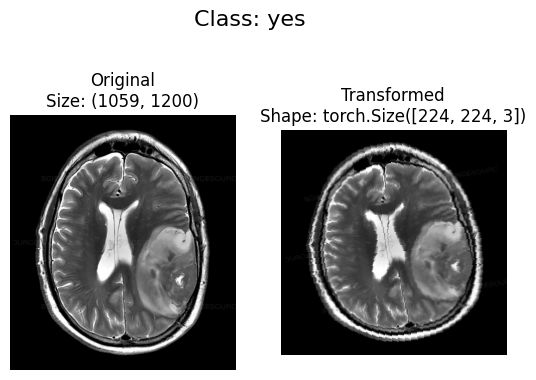

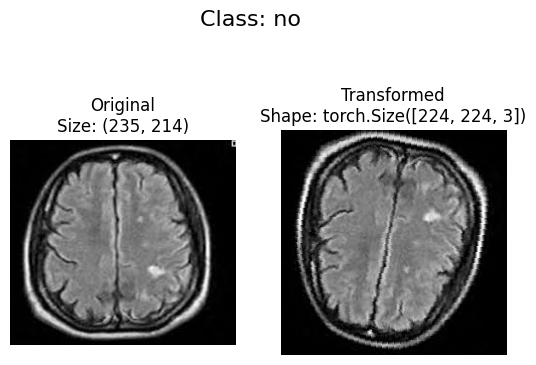

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=img_path_list,
                        transform=transform,
                        n=3,
                        seed=None)

## 1.2 Creating Dataset and DataLoader

In [ ]:
dataset = datasets.ImageFolder(root=img_path,
                               transform=transform,
                               target_transform=None)

#used to shuffle the dataset before splitting into testing and training
generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset = random_split(dataset,
                                          [round(len(dataset)*0.8), round(len(dataset)*0.2)],
                                          generator=generator)

class_names = dataset.classes
class_dict = dataset.class_to_idx


In [ ]:
BATCH_SIZE=10
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

# 2.0 Model Definition

In [ ]:
class TumorPredictCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56,
                  out_features=hidden_units*2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=hidden_units*2, out_features=output_shape)
    )
  def forward(self,x):
    # x = self.convblock1(x)
    # print(x.shape)
    # x = self.convblock2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    return self.classifier(self.convblock2(self.convblock1(x)))


In [ ]:
model = TumorPredictCNN(input_shape=3,
                        hidden_units=8,
                        output_shape=len(class_names)).to(device)
model

TumorPredictCNN(
  (convblock1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, s

In [ ]:
imgtest , labeltest = next(iter(train_dataloader))
output = model(imgtest.to(device))
output.shape

torch.Size([10, 2])

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TumorPredictCNN                          [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 112, 112]          --
│    └─Conv2d: 2-1                       [1, 8, 224, 224]          224
│    └─BatchNorm2d: 2-2                  [1, 8, 224, 224]          16
│    └─LeakyReLU: 2-3                    [1, 8, 224, 224]          --
│    └─Conv2d: 2-4                       [1, 8, 224, 224]          584
│    └─BatchNorm2d: 2-5                  [1, 8, 224, 224]          16
│    └─LeakyReLU: 2-6                    [1, 8, 224, 224]          --
│    └─MaxPool2d: 2-7                    [1, 8, 112, 112]          --
├─Sequential: 1-2                        [1, 8, 56, 56]            --
│    └─Conv2d: 2-8                       [1, 8, 112, 112]          584
│    └─BatchNorm2d: 2-9                  [1, 8, 112, 112]          16
│    └─LeakyReLU: 2-10                   [1, 8, 112, 112]          --
│    └─Conv2

## 2.1 Training and Testing

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)
NUM_EPOCHS = 20
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=lossfn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0507 | Train acc: 0.6143 | Test loss: 0.6626 | Test acc: 0.7667
Epoch: 2 | Train loss: 0.5502 | Train acc: 0.7048 | Test loss: 0.5860 | Test acc: 0.7833
Epoch: 3 | Train loss: 0.6117 | Train acc: 0.6000 | Test loss: 0.5011 | Test acc: 0.6833
Epoch: 4 | Train loss: 0.5685 | Train acc: 0.7000 | Test loss: 0.6151 | Test acc: 0.4833
Epoch: 5 | Train loss: 0.6086 | Train acc: 0.6905 | Test loss: 1.3220 | Test acc: 0.5333
Epoch: 6 | Train loss: 0.5940 | Train acc: 0.6762 | Test loss: 0.5950 | Test acc: 0.6167
Epoch: 7 | Train loss: 0.5035 | Train acc: 0.6905 | Test loss: 0.5180 | Test acc: 0.8000
Epoch: 8 | Train loss: 0.4891 | Train acc: 0.7190 | Test loss: 0.4666 | Test acc: 0.8333
Epoch: 9 | Train loss: 0.3960 | Train acc: 0.7524 | Test loss: 0.5925 | Test acc: 0.7333
Epoch: 10 | Train loss: 0.3533 | Train acc: 0.8000 | Test loss: 0.6735 | Test acc: 0.7667
Epoch: 11 | Train loss: 0.3408 | Train acc: 0.8476 | Test loss: 0.5856 | Test acc: 0.8000
Epoch: 12 | Train l

# 3.0 Plotting Results

In [ ]:
def plot_loss_curves(results):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

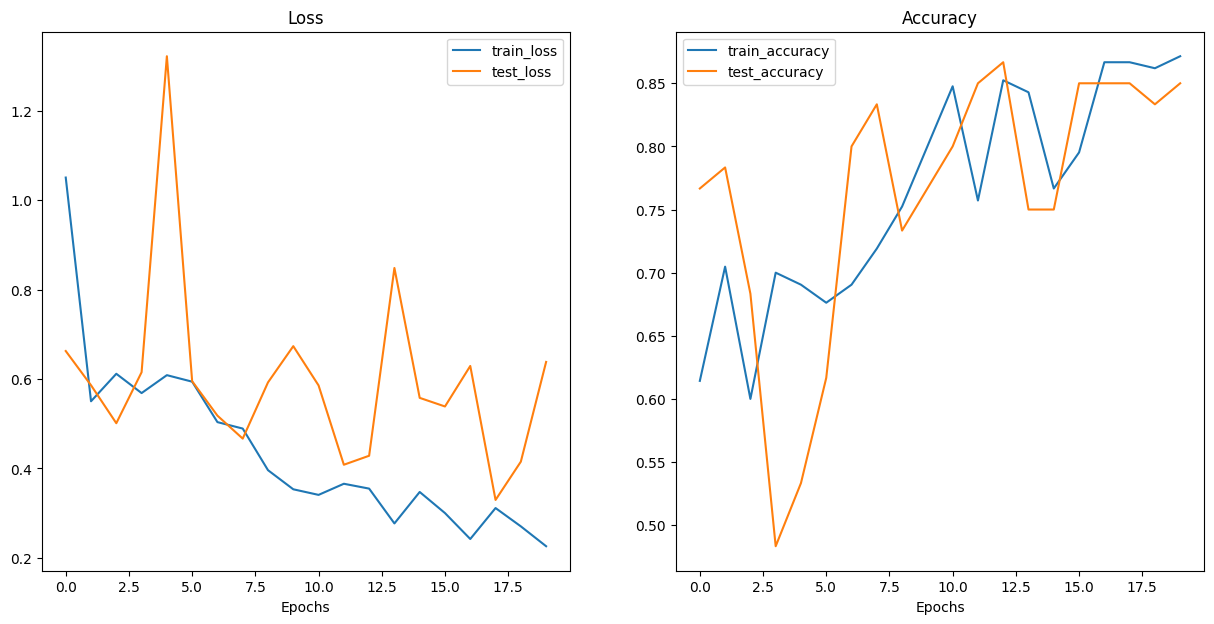

In [ ]:
plot_loss_curves(model_results)